# Case 3: Recheio Customer Data Enrichment & Recommendation Engine

## Overview
This case study focuses on enriching Recheio Cash & Carry’s customer dataset to deliver more relevant product recommendations across digital channels such as the website, mobile app, POS, and contact center. The project combines customer segmentation and association rule mining to develop systems like **Smart Baskets** and **Did You Forget**, enhancing customer experience and increasing Recheio’s share in total customer purchases.

## Business Problem
- Recheio serves two distinct segments (HoReCa and Traditional Retail), each with unique needs.  
- Customer relationship and loyalty are heavily dependent on personalized and insightful interactions.  
- Current data systems are fragmented, limiting the ability to generate impactful recommendations.  
- There is a need to increase **Recheio’s share of wallet** by becoming more relevant in each customer’s purchasing behavior.

## Objective
- **Enrich the customer dataset** with relevant external or engineered information.  
- **Segment customers** and **Generate association rules** to recommend products using logic like **Smart Baskets** and **Did You Forget**.  
- **Validate the recommendations** using offline evaluation metrics.

---

**This notebook was developed by:**  
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564


# 1.Import Libraries

In [1]:
import calendar
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder

In [2]:
clients = pd.read_excel("Case3_Recheio_2025.xlsx",sheet_name=0, header=1)
clients = clients.iloc[:, 1:]
clients

,Client ID,ZIP Code,ID Client Type
0,210100002,4049,NaN
1,210100003,4000,NaN
2,210100004,4149,NaN
3,210100005,4100,Hotelaria
4,210100006,4405,NaN
...,...,...,...
6457,210199921,4750,NaN
6458,210199922,3004,NaN
6459,210199928,4100,NaN
6460,210199937,4520,NaN


In [3]:
products = pd.read_excel("Case3_Recheio_2025.xlsx",sheet_name=1,header=1)
products = products.iloc[:, 1:]
products

,ID Product,Product Description,ID Product Category
0,224780,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS
1,276806,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS
2,276809,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS
3,277674,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS
4,277917,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS
...,...,...,...
4578,962871,PETIT GATEAU CHOCOLATE PRETO ROLO 16X80G,BOLOS E SOBREMESAS INDIVIDUAIS
4579,863666,TOSTAS AMANH C/PASSAS 150GR,PRODUTOS DE PADARIA
4580,975316,POLVO FRIBO T7 FLÔR DE 500/800 KG,CEFALÓPODES
4581,617063,NATAS PARMALAT P/CULIN. 1 LT,NATAS


In [4]:
transactions = pd.read_excel("Case3_Recheio_2025.xlsx",sheet_name=2, header=1)
transactions = transactions.iloc[:, 1:]
transactions

,Date,Client ID,ID Product
0,2022-01-02,210100281,224780
1,2022-01-02,210100281,276806
2,2022-01-02,210100281,276809
3,2022-01-02,210100281,277674
4,2022-01-02,210100281,277917
...,...,...,...
884094,2022-12-31,210106386,949447
884095,2022-12-31,210106386,954062
884096,2022-12-31,210199916,106702
884097,2022-12-31,210199916,906800


### EDA

In [5]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6462 entries, 0 to 6461
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Client ID       6462 non-null   int64 
 1   ZIP Code        6462 non-null   int64 
 2   ID Client Type  680 non-null    object
dtypes: int64(2), object(1)
memory usage: 151.6+ KB


In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4583 entries, 0 to 4582
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID Product           4583 non-null   int64 
 1   Product Description  4583 non-null   object
 2   ID Product Category  4583 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.5+ KB


In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884099 entries, 0 to 884098
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        884099 non-null  datetime64[ns]
 1   Client ID   884099 non-null  int64         
 2   ID Product  884099 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 20.2 MB


### Verify Duplicates

In [8]:
client_duplicates = clients.duplicated(subset=['Client ID']).sum()
print(f"Number of duplicate Client IDs: {client_duplicates}")

product_id_duplicates = products.duplicated(subset=['ID Product']).sum()
print(f"Number of duplicate Product IDs: {product_id_duplicates}")

product_desc_duplicates = products.duplicated(subset=['Product Description']).sum()
print(f"Number of duplicate Product Descriptions: {product_desc_duplicates}")

Number of duplicate Client IDs: 0
Number of duplicate Product IDs: 0
Number of duplicate Product Descriptions: 10


Check if the Duplicate Product Description correspond to  the same Product Categories

In [9]:
duplicate_descriptions = products[products.duplicated(subset=['Product Description'], keep=False)]

category_check = duplicate_descriptions.groupby('Product Description')['ID Product Category'].nunique().reset_index()

conflicting_descriptions = category_check[category_check['ID Product Category'] > 1]

if not conflicting_descriptions.empty:
    print("Product Descriptions with conflicting categories:")
    conflict_rows = products[products['Product Description'].isin(conflicting_descriptions['Product Description'])]
    print(conflict_rows)
else:
    print("All duplicate Product Descriptions have the same Product Category.")


All duplicate Product Descriptions have the same Product Category.


### Number of Transactions Over Time


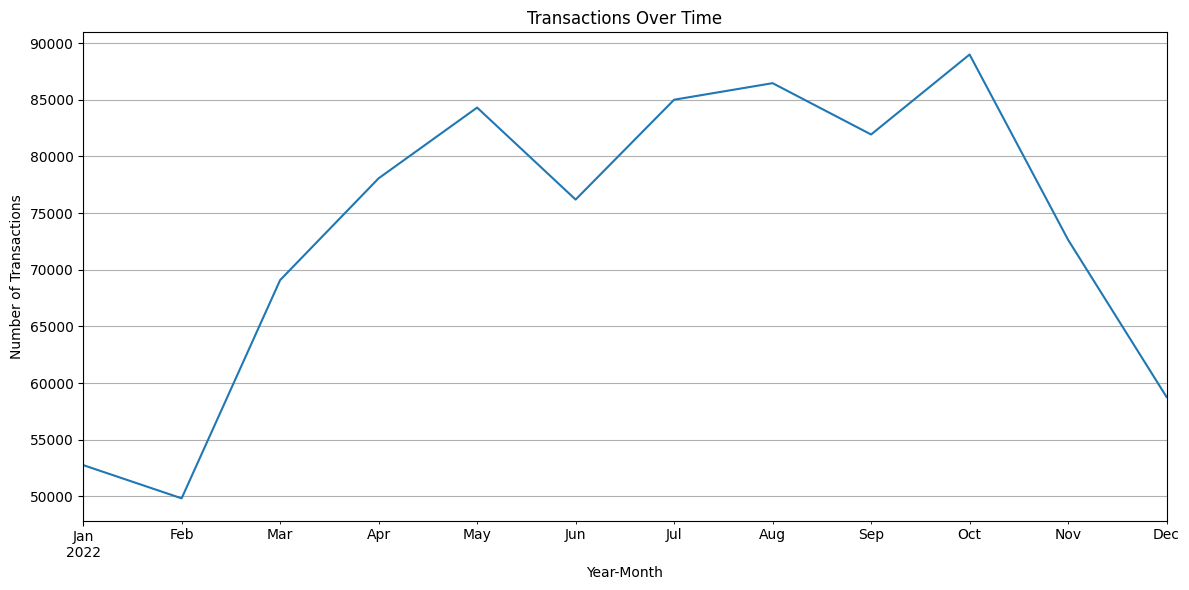

In [10]:
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions['YearMonth'] = transactions['Date'].dt.to_period('M')

tx_by_month = transactions.groupby('YearMonth').size()

tx_by_month.plot(kind='line', figsize=(12,6), title='Transactions Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()


### Best-Selling Products

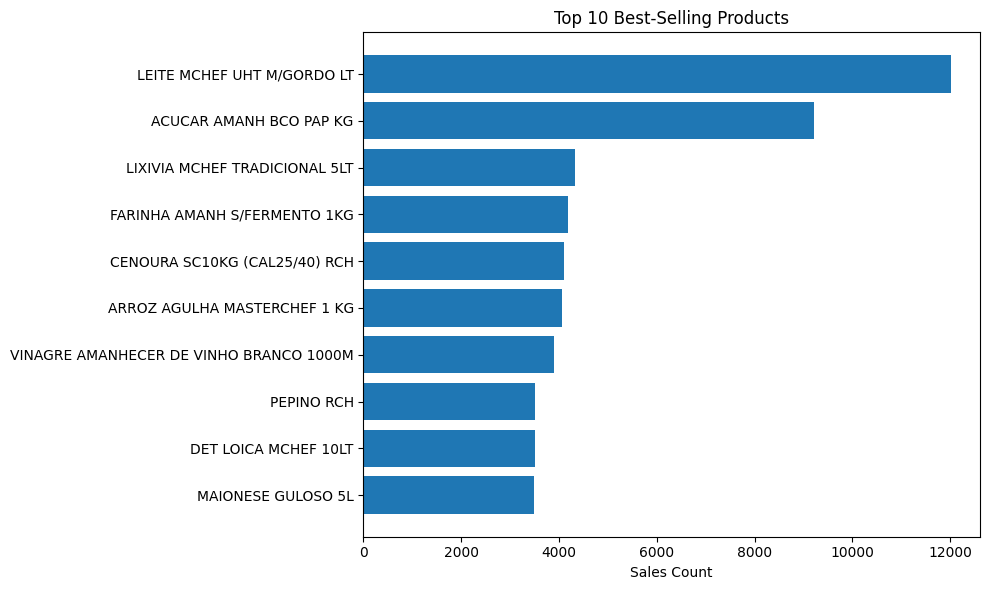

In [11]:
top_products = transactions['ID Product'].value_counts().head(10).reset_index()
top_products.columns = ['ID Product', 'Sales Count']
top_products = top_products.merge(products, on='ID Product')

plt.figure(figsize=(10, 6))
plt.barh(top_products['Product Description'], top_products['Sales Count'])
plt.xlabel('Sales Count')
plt.title('Top 10 Best-Selling Products')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Client Type

C:\Users\jgven\AppData\Local\Temp\ipykernel_22108\3764846086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=client_types.index, y=client_types.values, palette='Greens_d')


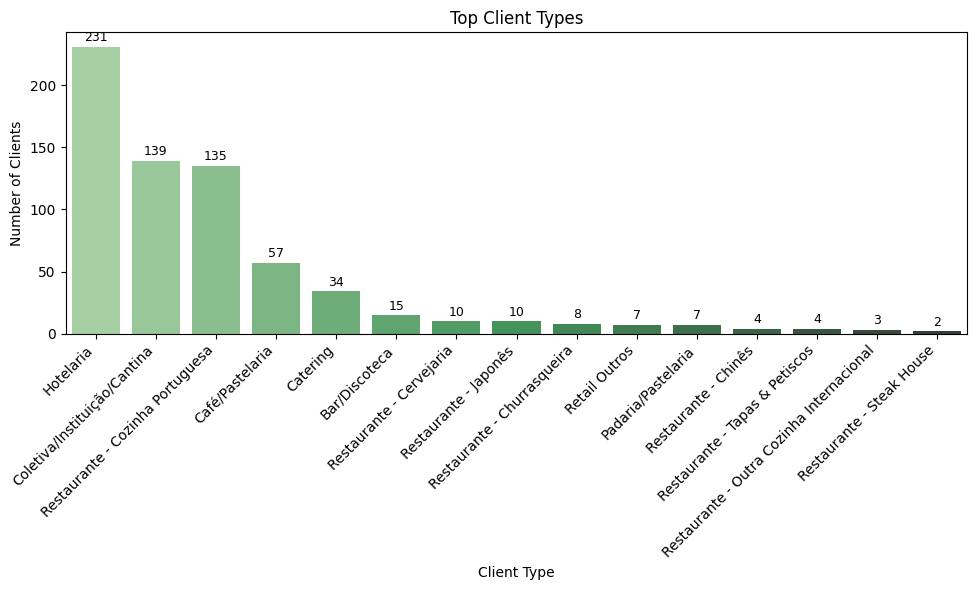

In [12]:
top_n = 15
client_types = clients['ID Client Type'].value_counts().nlargest(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=client_types.index, y=client_types.values, palette='Greens_d')
plt.title('Top Client Types')
plt.xlabel('Client Type')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, v in enumerate(client_types.values):
    plt.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=9)

plt.show()

Number of unique product categories

In [13]:
category_counts = products['ID Product Category'].value_counts()

print(f"Number of unique product categories: {products['ID Product Category'].nunique()}")
print(category_counts)

Number of unique product categories: 268
ID Product Category
VINHOS TINTOS                 175
CONSERVAS VEGETAIS            172
MOLHOS                        159
VINHOS BRANCOS                148
LEGUMES FRESCOS               133
                             ... 
FERMENTO FRESCO                 1
MORTADELA                       1
LEITE EM PÓ                     1
DOCES E CREMES PARA BARRAR      1
SAZONAIS                        1
Name: count, Length: 268, dtype: int64


### Merge the Dataset

In [14]:
transactions_clients = transactions.merge(clients, on='Client ID', how='left')
data = transactions_clients.merge(products, on='ID Product', how='left')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884099 entries, 0 to 884098
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 884099 non-null  datetime64[ns]
 1   Client ID            884099 non-null  int64         
 2   ID Product           884099 non-null  int64         
 3   YearMonth            884099 non-null  period[M]     
 4   ZIP Code             884099 non-null  int64         
 5   ID Client Type       389817 non-null  object        
 6   Product Description  884099 non-null  object        
 7   ID Product Category  884099 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3), period[M](1)
memory usage: 54.0+ MB
None


In [15]:
data.head(5)

,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category
0,2022-01-02,210100281,224780,2022-01,4400,Café/Pastelaria,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS
1,2022-01-02,210100281,276806,2022-01,4400,Café/Pastelaria,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS
2,2022-01-02,210100281,276809,2022-01,4400,Café/Pastelaria,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS
3,2022-01-02,210100281,277674,2022-01,4400,Café/Pastelaria,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS
4,2022-01-02,210100281,277917,2022-01,4400,Café/Pastelaria,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS


In [16]:
unique_clients = data['Client ID'].nunique()
print(f"Number of unique clients: {unique_clients}")

Number of unique clients: 1529


In [17]:
category_counts = data['ID Product Category'].value_counts()
print(f"Number of unique product categories: {data['ID Product Category'].nunique()}")
print(category_counts)

Number of unique product categories: 268
ID Product Category
LEGUMES FRESCOS             62717
CONSERVAS VEGETAIS          50190
FRUTAS FRESCAS              48627
MOLHOS                      32396
4A GAMA                     19502
                            ...  
ESPECIALIDADES PEIXE            1
PEIXE FRESCO AQUICULTURA        1
LOUÇAS REGIONAIS                1
PASTAS                          1
HIGIENE BEBÉ                    1
Name: count, Length: 268, dtype: int64


### Feature Engeneering

RFM Analysis

In [18]:
test_data = data.copy()

snapshot_date = test_data['Date'].max() + pd.Timedelta(days=1)

rfm = test_data.groupby('Client ID').agg(
    Recency=('Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Date', 'nunique'),
    Monetary=('ID Product', 'count')
).reset_index()

test_data = test_data.merge(rfm, on='Client ID', how='left')


RFM Distribution

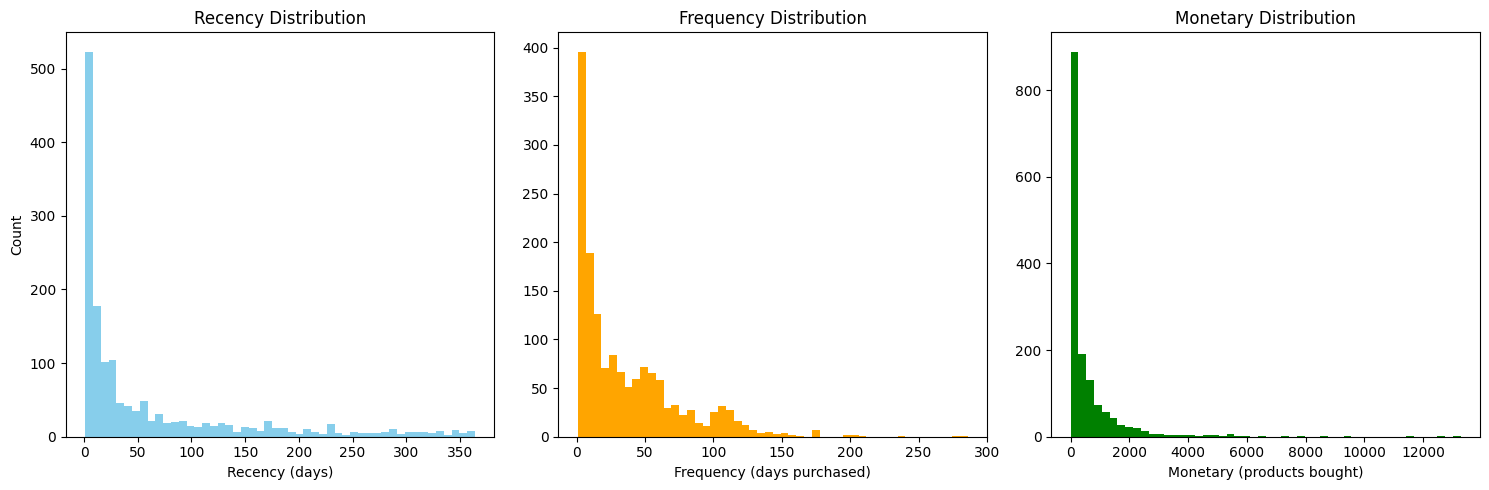

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(test_data.drop_duplicates('Client ID')['Recency'], bins=50, color='skyblue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Count')

axes[1].hist(test_data.drop_duplicates('Client ID')['Frequency'], bins=50, color='orange')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Frequency (days purchased)')

axes[2].hist(test_data.drop_duplicates('Client ID')['Monetary'], bins=50, color='green')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Monetary (products bought)')

plt.tight_layout()
plt.show()

Log Transformation on RFM

In [20]:
rfm_data = test_data.drop_duplicates('Client ID')[['Client ID', 'Recency', 'Frequency', 'Monetary']].copy()

rfm_data['Log_Recency'] = np.log1p(rfm_data['Recency'])
rfm_data['Log_Frequency'] = np.log1p(rfm_data['Frequency'])
rfm_data['Log_Monetary'] = np.log1p(rfm_data['Monetary'])

test_data = test_data.merge(rfm_data[['Client ID', 'Log_Recency', 'Log_Frequency', 'Log_Monetary']], on='Client ID', how='left')

print(test_data[['Client ID', 'Recency', 'Log_Recency', 'Frequency', 'Log_Frequency', 'Monetary', 'Log_Monetary']].head())

   Client ID  Recency  Log_Recency  Frequency  Log_Frequency  Monetary  \
0  210100281        1     0.693147        106       4.672829      2338   
1  210100281        1     0.693147        106       4.672829      2338   
2  210100281        1     0.693147        106       4.672829      2338   
3  210100281        1     0.693147        106       4.672829      2338   
4  210100281        1     0.693147        106       4.672829      2338   

   Log_Monetary  
0      7.757479  
1      7.757479  
2      7.757479  
3      7.757479  
4      7.757479  


Weekly Purchase Percentage Features 

In [21]:
test_data['Weekday'] = test_data['Date'].dt.weekday

weekday_counts = test_data.groupby(['Client ID', 'Weekday']).size().reset_index(name='Count')

total_counts = weekday_counts.groupby('Client ID')['Count'].sum().reset_index(name='Total')

weekday_counts = weekday_counts.merge(total_counts, on='Client ID')

weekday_counts['Percentage'] = weekday_counts['Count'] / weekday_counts['Total']

weekday_pivot = weekday_counts.pivot(index='Client ID', columns='Weekday', values='Percentage').fillna(0)

weekday_pivot.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

test_data = test_data.merge(weekday_pivot, on='Client ID', how='left')


Average Number of Products Bought per Week and Average Number of Products per Purchase

In [22]:
test_data['YearWeek'] = test_data['Date'].dt.strftime('%Y-%U')

total_products = test_data.groupby('Client ID')['ID Product'].count().reset_index(name='Total_Products')
unique_weeks = test_data.groupby('Client ID')['YearWeek'].nunique().reset_index(name='Unique_Weeks')
unique_days = test_data.groupby('Client ID')['Date'].nunique().reset_index(name='Unique_Days')

agg_data = total_products.merge(unique_weeks, on='Client ID').merge(unique_days, on='Client ID')

agg_data['Avg_Products_Per_Week'] = agg_data['Total_Products'] / agg_data['Unique_Weeks']
agg_data['Avg_Products_Per_Purchase'] = agg_data['Total_Products'] / agg_data['Unique_Days']

test_data = test_data.merge(agg_data[['Client ID', 'Avg_Products_Per_Week', 'Avg_Products_Per_Purchase']], on='Client ID', how='left')

See the unique zip codes and their respective counts

In [23]:
zip_counts = test_data['ZIP Code'].value_counts().reset_index()
zip_counts.columns = ['ZIP Code', 'Count']
zip_counts = zip_counts.sort_values('ZIP Code', ascending=True)
print(zip_counts)


     ZIP Code  Count
121      1100      2
109      1349     61
123      2414      1
116      2420     13
119      2485      8
..        ...    ...
92       5150    245
83       5370    392
88       5400    323
107      6300     64
106      6420     76

[124 rows x 2 columns]


Zip Code into Region

In [24]:
def map_region(zip_code):
    if 1000 <= zip_code <= 1999:
        return 'Lisboa'
    elif 2000 <= zip_code <= 2999:
        return 'Centro'
    elif 3000 <= zip_code <= 3999:
        return 'Centro'
    elif 4000 <= zip_code <= 4999:
        return 'Porto'
    elif 5000 <= zip_code <= 5999:
        return 'Norte'
    elif 6000 <= zip_code <= 6999:
        return 'Sul'
    elif 9000 <= zip_code <= 9999:
        return 'Ilhas'
    else:
        return 'Outros'

test_data['Region'] = test_data['ZIP Code'].apply(map_region)

region_dummies = pd.get_dummies(test_data['Region'], prefix='Region')

test_data = pd.concat([test_data, region_dummies], axis=1)

region_cols = [col for col in test_data.columns if col.startswith('Region_')]
test_data[region_cols] = test_data[region_cols].astype(int)

Most Relevant Categories

In [25]:
counts = (
    test_data
    .groupby('ID Product Category')
    .size()
    .reset_index(name='Count')
)

print("\nContagem por valor em 'ID Product Category' no test_data:")
print(counts.to_string(index=False))


Contagem por valor em 'ID Product Category' no test_data:
                  ID Product Category  Count
                                    0    215
                              4A GAMA  19502
                              ABSINTO      4
                ACESSORIOS TRANSPORTE   6249
             ACESSÓRIOS LIMPEZA GERAL    397
                        ACHOCOLATADOS    419
                       ACOMPANHAMENTO   2711
                       ADITIVOS ROUPA     56
                    AFINS DE BACALHAU    439
                           AGUARDENTE    418
                             ALHEIRAS   1743
                   ALIMENTOS INFANTIS   1712
                    AMACIADORES ROUPA    154
                           APERITIVOS   1018
            APERITIVOS E BATATA FRITA   3394
                                ARROZ  18858
                     ARTIGOS DE FESTA     17
                     ARTIGOS DESCONTO    149
                            AUTOMÓVEL    385
                 AVES / CAÇA / COELHO   6

Aggregate Categories

In [26]:
horeca_cats = [
    'ACOMPANHAMENTO',
    'PRATO DE CARNE',
    'PRATO VEGETARIANO',
    'PRATO DE PEIXE',
    'SOPAS',
    'SOBREMESAS'
]

mask_horeca = (
    test_data['ID Product Category'].isin(horeca_cats) &
    test_data['Product Description'].str.contains(r'\*', regex=True, na=False)
)

horeca = test_data[mask_horeca].copy()

test_data = test_data[~mask_horeca].copy()

print(f"Horeca: {horeca.shape[0]} rows")
print(f"test_data restante: {test_data.shape[0]} rows")

Horeca: 10024 rows
test_data restante: 874075 rows


In [27]:
category_mapping = {
    'LEGUMES FRESCOS':                 'Vegetais e Frutas',
    'CONSERVAS VEGETAIS':              'Conservas e Enlatados',
    'FRUTAS FRESCAS':                  'Vegetais e Frutas',
    'MOLHOS':                          'Secos e Básicos de cozinha',
    '4A GAMA':                         'Vegetais e Frutas',
    'ÓLEOS':                           'Secos e Básicos de cozinha',
    'ARROZ':                           'Secos e Básicos de cozinha',
    'ESPECIARIAS':                     'Secos e Básicos de cozinha',
    'LEITE UHT REGULAR':               'Laticínios e Ovos',
    'IOGURTES':                        'Laticínios e Ovos',
    'AÇÚCAR':                          'Secos e Básicos de cozinha',
    'NATAS':                           'Laticínios e Ovos',
    'FARINHAS':                        'Secos e Básicos de cozinha',
    'VINHOS BRANCOS':                  'Bebidas Alcoólicas',
    'HORTÍCOLAS CONSERVAÇÃO':          'Vegetais e Frutas',
    'ÁGUAS LISAS':                     'Bebidas Não-Alcoólicas',
    'MANTEIGAS':                       'Laticínios e Ovos',
    'CARBONATADOS':                    'Bebidas Não-Alcoólicas',
    'SOBREMESAS':                      'Doces e Snacks',
    'MASSAS':                          'Secos e Básicos de cozinha',
    'AZEITES':                         'Secos e Básicos de cozinha',
    'PADARIA':                         'Padaria / Pastelaria',
    'OVOS GAIOLA':                     'Laticínios e Ovos',
    'FRUTAS EM CONSERVA':              'Conservas e Enlatados',
    'SAL':                             'Secos e Básicos de cozinha',
    'PASTELARIA':                      'Padaria / Pastelaria',
    'VINAGRES':                        'Secos e Básicos de cozinha',
    'FIAMBRES':                        'Talho',
    'MEL E DOCES':                     'Doces e Snacks',
    'GELADOS CATERING':                'Doces e Snacks',
    'VEGETAIS DE FOLHA E CRUCÍFEROS':  'Vegetais e Frutas',
    'VINHOS TINTOS':                   'Bebidas Alcoólicas',
    'PRODUTOS DE PADARIA':             'Padaria / Pastelaria',
    'CONSERVAS ATUM':                  'Conservas e Enlatados',
    'OVOS PROCESSADOS':                'Laticínios e Ovos',
    'FRUTOS SECOS':                    'Secos e Básicos de cozinha',
    'AVES / CAÇA / COELHO':            'Talho',
    'PESCADO AQUICULTURA':             'Peixaria',
    'BOVINO':                          'Talho',
    'OUTROS QUEIJOS ESTRANGEIROS':     'Laticínios e Ovos',
    'BATATA':                          'Doces e Snacks',
    'PRODUTOS PARA DOÇARIA':           'Secos e Básicos de cozinha',
    'ACESSORIOS TRANSPORTE':           'Produtos Não Alimentares',
    'DETERGENTE LOIÇA':                'Produtos Não Alimentares',
    'SUINO':                           'Talho',
    'BOLACHAS':                        'Doces e Snacks',
    'CREMES VEGETAIS':                 'Laticínios e Ovos',
    'CHOCOLATE':                       'Doces e Snacks',
    'SACOS LIXO':                      'Produtos Não Alimentares',
    'FLAMENGO':                        'Laticínios e Ovos',
    'CONSERVAÇÃO DE ALIMENTOS':        'Produtos Não Alimentares',
    'FRUTAS':                          'Vegetais e Frutas',
    'BACON':                           'Talho',
    'BOLOS E SOBREMESAS INDIVIDUAIS':  'Doces e Snacks',
    'LEGUMINOSAS E GRÃOS':             'Vegetais e Frutas',
    'CONDIMENTOS':                     'Secos e Básicos de cozinha',
    'LIXÍVIAS TRADICIONAIS':           'Produtos Não Alimentares',
    'SALGADOS / SNACKS E ENTRADAS':    'Doces e Snacks',
    'ÁGUAS COM GÁS':                   'Bebidas Não-Alcoólicas',
    'QUEIJOS FRESCOS':                 'Laticínios e Ovos',
    'LUVAS':                           'Produtos Não Alimentares',
    'QUEIJOS PRATO':                   'Laticínios e Ovos',
    'VINHO DO PORTO':                  'Bebidas Alcoólicas',
    'CERVEJAS BRANCAS':                'Bebidas Alcoólicas',
    'NÃO CARBONATADOS':                'Bebidas Não-Alcoólicas',
    'CHÁS E INFUSÕES':                 'Bebidas Não-Alcoólicas',
    'CAFÉS E MISTURAS':                'Bebidas Não-Alcoólicas',
    'SUMOS 100 %':                     'Bebidas Não-Alcoólicas',
    'LICORES':                         'Bebidas Alcoólicas',
    'CEREAIS':                         'Secos e Básicos de cozinha',
    'AVES / COELHO':                   'Talho',
    'MASSAS REFRIGERADAS':             'Secos e Básicos de cozinha',
    'APERITIVOS E BATATA FRITA':       'Doces e Snacks',
    'VEGETAIS DIVERSOS E MISTURAS':    'Vegetais e Frutas',
    'EDAM':                            'Laticínios e Ovos',
    'QUEIJOS PARA BARRAR':             'Laticínios e Ovos',
    'PREPARADOS PEIXE':                'Peixaria',
    'MOZZARELLA':                      'Laticínios e Ovos',
    'SALSICHAS':                       'Conservas e Enlatados',
    'CHOURIÇOS':                       'Talho',
    'NÉCTARES':                        'Bebidas Não-Alcoólicas',
    'WHISKY':                          'Bebidas Alcoólicas',
    'PRESUNTOS':                       'Talho',
    'OUTROS QUEIJOS':                  'Laticínios e Ovos',
    'MULTIUSOS':                       'Produtos Não Alimentares',
    'BOLOS E SOBREMESAS FAMILIAR':     'Doces e Snacks',
    'SUMOS':                           'Bebidas Não-Alcoólicas',
    'PRODUTOS PARA O CHÃO':            'Produtos Não Alimentares',
    'PREPARADOS CARNE':                'Talho',
    'SOPAS INSTANTANEAS':              'Secos e Básicos de cozinha',
    'XAROPES':                         'Bebidas Não-Alcoólicas',
    'GUARDANAPOS FOLHA SIMPLES':       'Produtos Não Alimentares',
    'CAMARÃO':                         'Peixaria',
    'BEBIDA VEGETAL':                  'Bebidas Não-Alcoólicas',
    'COZINHA':                         'Produtos Não Alimentares',
    'CREMES PARA BARRAR':              'Doces e Snacks',
    'ALHEIRAS':                        'Talho',
    'ALIMENTOS INFANTIS':              'Secos e Básicos de cozinha',
    'CEFALÓPODES':                     'Peixaria',
    'VEGETAIS DE RAÍZ E BULBOS':       'Vegetais e Frutas',
    'PAPELARIA':                       'Produtos Não Alimentares',
    'ROLOS DE COZINHA':                'Produtos Não Alimentares',
    'LEITE DE COCO':                   'Secos e Básicos de cozinha',
    'PEIXE CONG EMBALADO':             'Peixaria',
    'ESPUMANTES NACIONAIS':            'Bebidas Alcoólicas',
    'BACALHAU':                        'Peixaria',
    'CHEDDAR':                         'Laticínios e Ovos',
    'BRANDY':                          'Bebidas Alcoólicas',
    'VINHOS ROSÉ':                     'Bebidas Alcoólicas',
    'PAPEL HIGIÉNICO':                 'Produtos Não Alimentares',
    'TOALHAS DE MÃO':                  'Produtos Não Alimentares',
    'DESCARTÁVEIS PAPEL E CARTÃO':     'Produtos Não Alimentares',
    'PÃO TAMANHO INDIVIDUAL':          'Padaria / Pastelaria',
    'DESCARTÁVEIS MADEIRA':            'Produtos Não Alimentares',
    'BANHA':                           'Secos e Básicos de cozinha',
    'CONCENTRADOS':                    'Bebidas Não-Alcoólicas',
    'PESCADO ESPECIALIDADES':          'Peixaria',
    'REBUÇADOS GOMAS E PASTILHAS':     'Doces e Snacks',
    'LEITE UHT ESPECIAL':              'Laticínios e Ovos',
    'CONSERVAS MAR ESPECIALIDADES':    'Conservas e Enlatados',
    'OUTROS VEGETAIS':                 'Vegetais e Frutas',
    'SEMENTES':                        'Secos e Básicos de cozinha',
    'PÃO TAMANHO GRANDE':             'Padaria / Pastelaria',
    'PRODUTOS DE SAÚDE':               'Produtos Não Alimentares',
    'LEITE UHT AROMATIZADO':           'Laticínios e Ovos',
    'CHOURIÇÃO':                       'Talho',
    'APERITIVOS':                      'Bebidas Alcoólicas',
    'GINS':                            'Bebidas Alcoólicas',
    'BIVALVES':                        'Peixaria',
    'RUM':                             'Bebidas Alcoólicas',
    'PROTEÍNA VEGETAL':                'Secos e Básicos de cozinha',
    'ILHA':                            'Laticínios e Ovos',
    'GUARDANAPOS FOLHA DUPLA':         'Produtos Não Alimentares',
    'VODKA':                           'Bebidas Alcoólicas',
    'PÃO MINI':                        'Padaria / Pastelaria',
    'PREPARADOS PEIXE E MARISCO':      'Peixaria',
    'PEIXES INTEIROS / CORTADOS':      'Peixaria',
    'TOALHAS DE MESA':                 'Produtos Não Alimentares',
    'ESPUMANTES ESTRANGEIROS':         'Bebidas Alcoólicas',
    'GELADOS MULTI-PACK':              'Doces e Snacks',
    'SALSICHAS FRESCAS':               'Talho',
    'LINGUIÇA':                        'Talho',
    'OVINO / CAPRINO':                 'Talho',
    'HAMBURGUERES / ALMONDEGAS / ESPETADAS': 'Talho',
    'DESCARTÁVEIS PAPEL':              'Produtos Não Alimentares',
    'MISTURAS DE VEGETAIS':            'Vegetais e Frutas',
    'PANOS':                           'Produtos Não Alimentares',
    'OVOS CODERNIZ':                   'Laticínios e Ovos',
    'QUEIJO PRATINHO':                 'Laticínios e Ovos',
    'MARISCO FRESCO':                  'Peixaria',
    'GOUDA':                           'Laticínios e Ovos',
    'OUTROS PÃES E ESPECIALIDADES':    'Padaria / Pastelaria',
    'GELATINAS':                       'Doces e Snacks',
    'SECANTES ABRILHANTADORES LOIÇA':  'Produtos Não Alimentares',
    'MARISCO COZIDO':                  'Peixaria',
    'AFINS DE BACALHAU':               'Peixaria',
    'EMMENTAL':                        'Laticínios e Ovos',
    'ACHOCOLATADOS':                   'Bebidas Não-Alcoólicas',
    'AGUARDENTE':                      'Bebidas Alcoólicas',
    'PAIOS':                           'Talho',
    'ACESSÓRIOS LIMPEZA GERAL':        'Produtos Não Alimentares',
    'FARDAMENTO':                      'Produtos Não Alimentares',
    'AUTOMÓVEL':                       'Produtos Não Alimentares',
    'OUTROS FUMADOS':                  'Talho',
    'CASA E JARDIM':                   'Produtos Não Alimentares',
    'CERVEJAS PRETAS':                 'Bebidas Alcoólicas',
    'PESCADO SELVAGEM':                'Peixaria',
    'VEGETARIANOS / VEGAN':            'Vegetais e Frutas',
    'DETERGENTES ROUPA':               'Produtos Não Alimentares',
    'PEIXE CONG HIGIENIZADO':          'Peixaria',
    'SABONETES':                       'Produtos Não Alimentares',
    'SALMÃO FUMADO':                   'Peixaria',
    'POLPAS DE FRUTA':                 'Vegetais e Frutas',
    'SIDRAS':                          'Bebidas Alcoólicas',
    'LAGOSTA, SAPATEIRA E OUTROS':     'Peixaria',
    'PATÉS E SIMILARES':               'Conservas e Enlatados',
    'TEQUILAS':                        'Bebidas Alcoólicas',
    'BOLOS E BISCOITOS':               'Doces e Snacks',
    'QUEIJOS REGIONAIS':               'Laticínios e Ovos',
    'TOALHETES':                       'Produtos Não Alimentares',
    'SUCEDÂNIO DE CAVIAR':             'Conservas e Enlatados',
    'UTENSILIOS COZINHA':              'Produtos Não Alimentares',
    'PIZZAS':                          'Doces e Snacks',
    'CERVEJAS INTERNACIONAIS':         'Bebidas Alcoólicas',
    'OUTROS ENCHIDOS':                 'Talho',
    'LIMPA VIDROS':                    'Produtos Não Alimentares',
    'PRODUTOS PARA CULINÁRIA':         'Secos e Básicos de cozinha',
    'FUNDIDO':                         'Laticínios e Ovos',
    'ÉTNICOS':                         'Secos e Básicos de cozinha',
    'VINHO MOSCATEL':                  'Bebidas Alcoólicas',
    'ESPINAFRES / GRELOS/ ESPARREGADO': 'Vegetais e Frutas',
    'PÃO DE HAMBÚRGUER':               'Padaria / Pastelaria',
    'CACHAÇA':                         'Bebidas Alcoólicas',
    'BAGUETE':                         'Padaria / Pastelaria',
    'BACALHAU INTEIRO':                'Peixaria',
    'COGNAC':                          'Bebidas Alcoólicas',
    'AMACIADORES ROUPA':               'Produtos Não Alimentares',
    'ARTIGOS DESCONTO':                'Produtos Não Alimentares',
    'SAZONAIS NATAL':                  'Doces e Snacks',
    'MORTADELA':                       'Talho',
    'SUMOS REFRIGERADOS':              'Bebidas Não-Alcoólicas',
    'ERVILHA':                         'Vegetais e Frutas',
    'FRISANTES BRANCOS':               'Bebidas Alcoólicas',
    'GUARDANAPOS FOLHA TRIPLA':        'Produtos Não Alimentares',
    'FRISANTES ROSÉ':                  'Bebidas Alcoólicas',
    'PATÉS':                           'Conservas e Enlatados',
    'DESCARTÁVEIS ALUMÍNIO':           'Produtos Não Alimentares',
    'SANGRIAS TINTAS':                 'Bebidas Alcoólicas',
    'VINHO MADEIRA':                   'Bebidas Alcoólicas',
    'LENÇOS DE PAPEL':                 'Produtos Não Alimentares',
    'GELADOS TAKE HOME':               'Doces e Snacks'
}

test_data['Macro_Category'] = test_data['ID Product Category'].map(category_mapping).fillna('Outros')

counts = (
    test_data
      .groupby('Macro_Category')
      .size()
      .reset_index(name='Count')
      .sort_values('Count', ascending=False)
)
print(counts.to_string(index=False))


            Macro_Category  Count
Secos e Básicos de cozinha 186260
         Vegetais e Frutas 168540
         Laticínios e Ovos 118083
     Conservas e Enlatados  71686
            Doces e Snacks  64844
  Produtos Não Alimentares  56449
    Bebidas Não-Alcoólicas  53671
                     Talho  50569
        Bebidas Alcoólicas  46063
      Padaria / Pastelaria  29600
                  Peixaria  23564
                    Outros   4746


In [28]:
df_counts = (
    test_data
      .groupby(['Client ID', 'Macro_Category'])
      .size()
      .reset_index(name='Count')
)

df_totals = (
    df_counts
      .groupby('Client ID')['Count']
      .sum()
      .reset_index(name='Total')
)

df_pct = (
    df_counts
      .merge(df_totals, on='Client ID')
)
df_pct['Pct'] = df_pct['Count'] / df_pct['Total']

customer_pct = (
    df_pct
      .pivot(index='Client ID', columns='Macro_Category', values='Pct')
      .fillna(0)
      .reset_index()
)

print(customer_pct.head())


Macro_Category  Client ID  Bebidas Alcoólicas  Bebidas Não-Alcoólicas  \
0               210100005            0.000000                0.024390   
1               210100012            0.000000                0.000000   
2               210100033            0.000805                0.013688   
3               210100051            0.008785                0.026354   
4               210100096            0.009259                0.000000   

Macro_Category  Conservas e Enlatados  Doces e Snacks  Laticínios e Ovos  \
0                            0.024390        0.012195           0.073171   
1                            0.000000        0.000000           0.000000   
2                            0.033011        0.118357           0.089372   
3                            0.124451        0.033675           0.325037   
4                            0.069444        0.125000           0.145833   

Macro_Category    Outros  Padaria / Pastelaria  Peixaria  \
0               0.000000              0.0000

In [29]:
test_data = test_data.merge(customer_pct, on='Client ID', how='left')
test_data.head(5)

,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category,Recency,Frequency,...,Conservas e Enlatados,Doces e Snacks,Laticínios e Ovos,Outros,Padaria / Pastelaria,Peixaria,Produtos Não Alimentares,Secos e Básicos de cozinha,Talho,Vegetais e Frutas
0,2022-01-02,210100281,224780,2022-01,4400,Café/Pastelaria,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS,1,106,...,0.124465,0.008127,0.050898,0.0,0.0,0.000428,0.021814,0.343456,0.00556,0.379812
1,2022-01-02,210100281,276806,2022-01,4400,Café/Pastelaria,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS,1,106,...,0.124465,0.008127,0.050898,0.0,0.0,0.000428,0.021814,0.343456,0.00556,0.379812
2,2022-01-02,210100281,276809,2022-01,4400,Café/Pastelaria,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS,1,106,...,0.124465,0.008127,0.050898,0.0,0.0,0.000428,0.021814,0.343456,0.00556,0.379812
3,2022-01-02,210100281,277674,2022-01,4400,Café/Pastelaria,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS,1,106,...,0.124465,0.008127,0.050898,0.0,0.0,0.000428,0.021814,0.343456,0.00556,0.379812
4,2022-01-02,210100281,277917,2022-01,4400,Café/Pastelaria,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS,1,106,...,0.124465,0.008127,0.050898,0.0,0.0,0.000428,0.021814,0.343456,0.00556,0.379812


Correlation Matrix

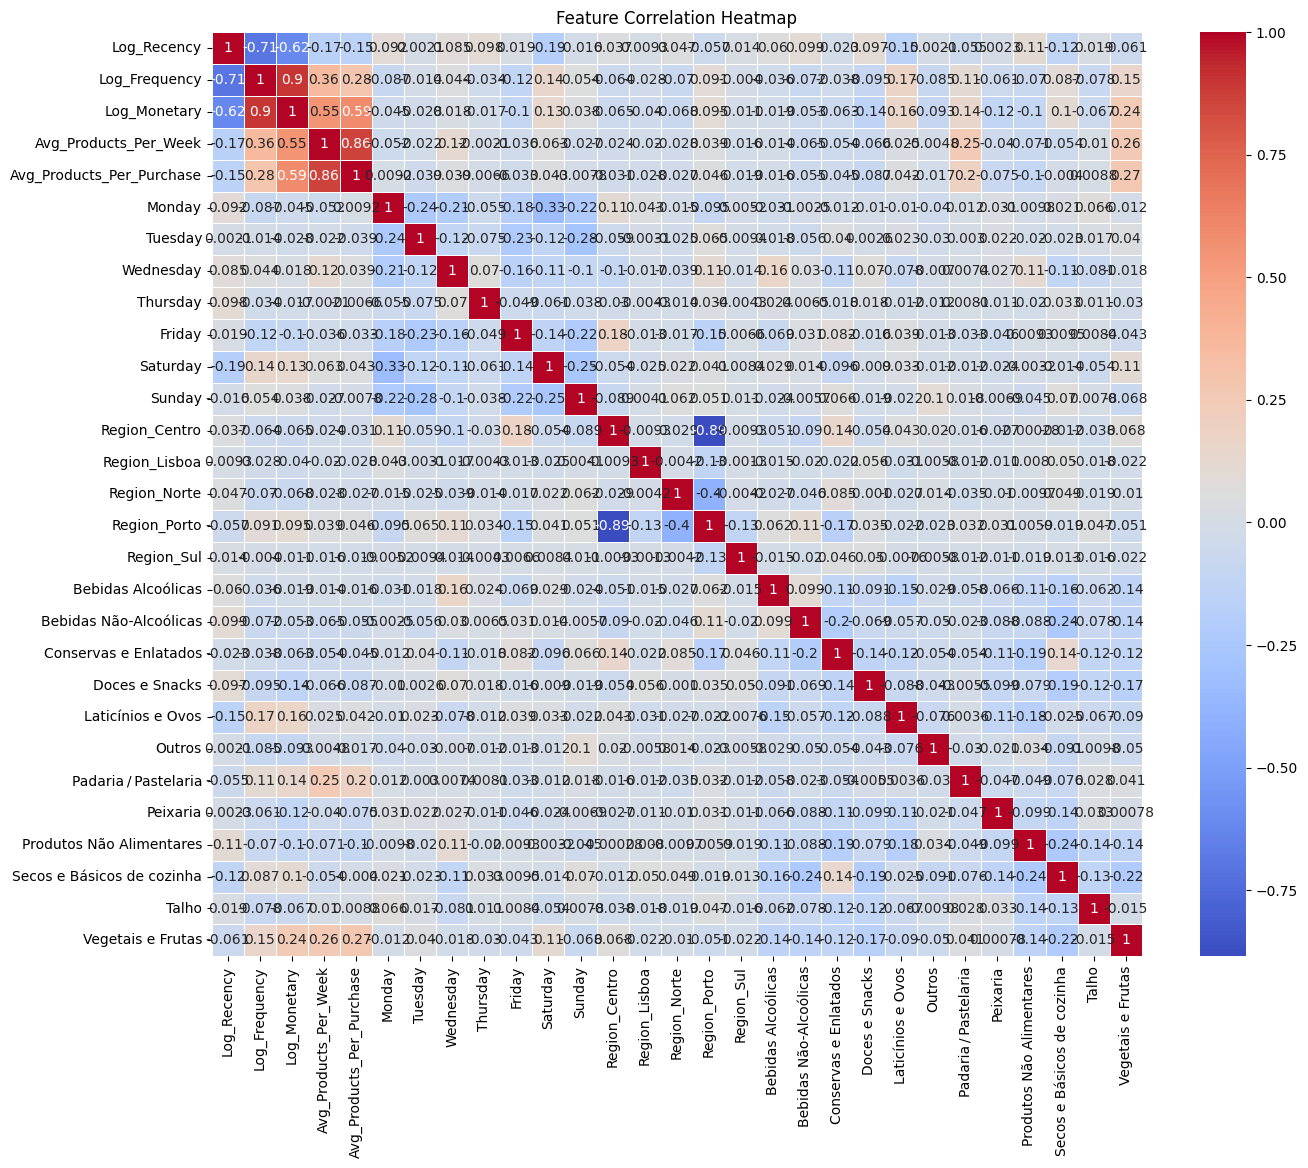

In [30]:
features = [
    # RFM logs
    'Log_Recency', 'Log_Frequency', 'Log_Monetary',
    # Average Products
    'Avg_Products_Per_Week', 'Avg_Products_Per_Purchase',
    # Days of the Week
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    # Region dummies
    'Region_Centro', 'Region_Lisboa', 'Region_Norte', 'Region_Porto', 'Region_Sul',
    # Macro-category dummies
    'Bebidas Alcoólicas', 'Bebidas Não-Alcoólicas', 'Conservas e Enlatados',
    'Doces e Snacks', 'Laticínios e Ovos', 'Outros',
    'Padaria / Pastelaria', 'Peixaria', 'Produtos Não Alimentares',
    'Secos e Básicos de cozinha', 'Talho', 'Vegetais e Frutas'
]

corr_data = test_data.drop_duplicates('Client ID')[features]

corr_matrix = corr_data.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

### Feature Selection Decisions

- The **log-transformed RFM variables** (`Log_Recency`, `Log_Frequency`, `Log_Monetary`) showed a **high correlation** among themselves.  
  Therefore, we decided to **retain only `Log_Frequency`**, as it best represents customer engagement frequency.

- **Average Products per Week** and **Average Products per Purchase** were also **highly correlated**.  
  To avoid redundancy, we **dropped Average Products per Week**, since it exhibited a slightly higher correlation with other variables.

- A similar logic was applied to the **correlation between Region_Porto and Region_Centro**.  
  Given the strong inverse relationship between the two, we **kept only Region_Centro** to maintain geographical representation without redundancy.


Drop Unnecessary Columns

In [31]:
cols_to_drop = [
    # Identifiers and Information about products
    'Date', 'ID Product', 'YearMonth', 'YearWeek', 'Weekday', 'ZIP Code', 'ID Client Type', 'Product Description', 
    'ID Product Category','Macro_Category', 'Avg_Products_Per_Week',

    # RFM 
    'Recency', 'Frequency', 'Monetary',   'Log_Recency', 'Log_Monetary',
    
    # Days of the Week
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',

    # Region dummies
    'Region_Centro', 'Region_Lisboa', 'Region_Norte', 'Region_Porto', 'Region_Sul', 'Region',
]

test_data = test_data.drop(columns=cols_to_drop)


In [32]:
test_data.columns

Index(['Client ID', 'Log_Frequency', 'Avg_Products_Per_Purchase',
       'Bebidas Alcoólicas', 'Bebidas Não-Alcoólicas', 'Conservas e Enlatados',
       'Doces e Snacks', 'Laticínios e Ovos', 'Outros', 'Padaria / Pastelaria',
       'Peixaria', 'Produtos Não Alimentares', 'Secos e Básicos de cozinha',
       'Talho', 'Vegetais e Frutas'],
      dtype='object')

Choosing Scaller

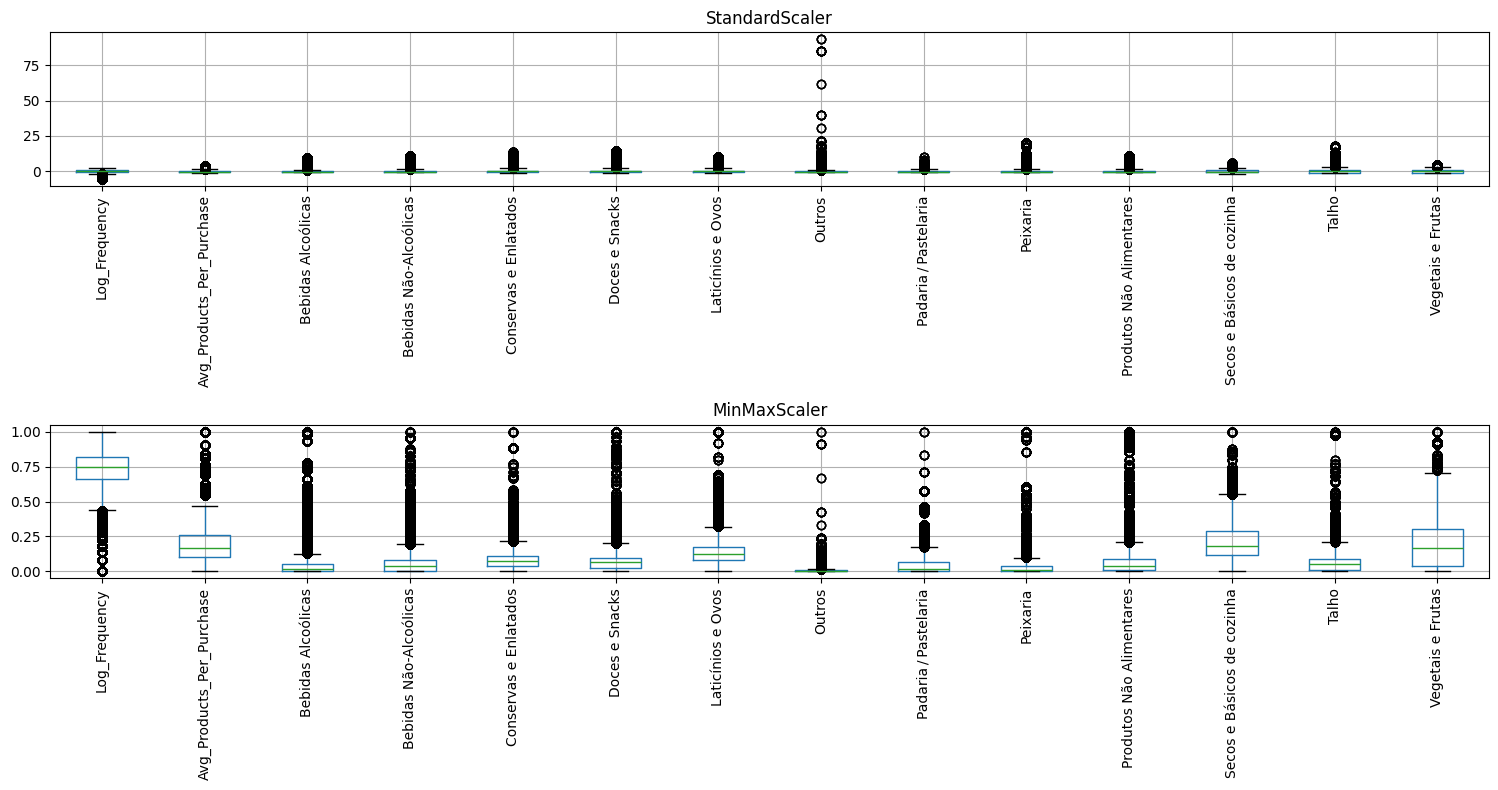

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

features_to_scale = test_data.drop(columns=['Client ID'])

standard_scaler = StandardScaler()
standard_scaled = standard_scaler.fit_transform(features_to_scale)
standard_scaled_df = pd.DataFrame(standard_scaled, columns=features_to_scale.columns)

minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(features_to_scale)
minmax_scaled_df = pd.DataFrame(minmax_scaled, columns=features_to_scale.columns)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

standard_scaled_df.boxplot(ax=axes[0], rot=90)
axes[0].set_title('StandardScaler')

minmax_scaled_df.boxplot(ax=axes[1], rot=90)
axes[1].set_title('MinMaxScaler')

plt.tight_layout()
plt.show()


Applying Min-Max Scaler

In [34]:
client_ids = test_data['Client ID']
features_to_scale = test_data.drop(columns=['Client ID'])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features_to_scale)

scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
scaled_df['Client ID'] = client_ids.values  

print(scaled_df.head())


   Log_Frequency  Avg_Products_Per_Purchase  Bebidas Alcoólicas  \
0       0.801332                   0.167613            0.051326   
1       0.801332                   0.167613            0.051326   
2       0.801332                   0.167613            0.051326   
3       0.801332                   0.167613            0.051326   
4       0.801332                   0.167613            0.051326   

   Bebidas Não-Alcoólicas  Conservas e Enlatados  Doces e Snacks  \
0                0.014115               0.124465        0.008127   
1                0.014115               0.124465        0.008127   
2                0.014115               0.124465        0.008127   
3                0.014115               0.124465        0.008127   
4                0.014115               0.124465        0.008127   

   Laticínios e Ovos  Outros  Padaria / Pastelaria  Peixaria  \
0           0.050898     0.0                   0.0  0.000428   
1           0.050898     0.0                   0.0  0.000428

Cumulative Explained Variance per PC

In [35]:
from sklearn.decomposition import PCA

features_for_pca = scaled_df.drop(columns=['Client ID'])

pca = PCA(n_components=None)
pca_components = pca.fit_transform(features_for_pca)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

for i, cumulative in enumerate(cumulative_variance):
    print(f'Component {i+1}: {cumulative:.4f}')


Component 1: 0.3422
Component 2: 0.5070
Component 3: 0.6205
Component 4: 0.7278
Component 5: 0.8059
Component 6: 0.8557
Component 7: 0.8977
Component 8: 0.9257
Component 9: 0.9486
Component 10: 0.9686
Component 11: 0.9859
Component 12: 0.9993
Component 13: 1.0000
Component 14: 1.0000


Top features per PC

In [36]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
    index=features_for_pca.columns
)

for pc in loadings.columns:
    print(f"\nTop features for {pc}:")
    top_features = loadings[pc].abs().sort_values(ascending=False).head(3)
    for feature, weight in top_features.items():
        print(f"  {feature}: {weight:.4f}")



Top features for PC1:
  Avg_Products_Per_Purchase: 0.6642
  Vegetais e Frutas: 0.5494
  Secos e Básicos de cozinha: 0.3521

Top features for PC2:
  Avg_Products_Per_Purchase: 0.6697
  Vegetais e Frutas: 0.6122
  Secos e Básicos de cozinha: 0.3125

Top features for PC3:
  Secos e Básicos de cozinha: 0.6015
  Bebidas Alcoólicas: 0.4765
  Bebidas Não-Alcoólicas: 0.3924

Top features for PC4:
  Log_Frequency: 0.8307
  Vegetais e Frutas: 0.3054
  Padaria / Pastelaria: 0.2698

Top features for PC5:
  Bebidas Alcoólicas: 0.5496
  Laticínios e Ovos: 0.4860
  Padaria / Pastelaria: 0.3793

Top features for PC6:
  Produtos Não Alimentares: 0.8222
  Laticínios e Ovos: 0.5017
  Bebidas Não-Alcoólicas: 0.1365

Top features for PC7:
  Padaria / Pastelaria: 0.6658
  Laticínios e Ovos: 0.4852
  Doces e Snacks: 0.3344

Top features for PC8:
  Bebidas Não-Alcoólicas: 0.7408
  Bebidas Alcoólicas: 0.3921
  Conservas e Enlatados: 0.3669

Top features for PC9:
  Conservas e Enlatados: 0.4263
  Padaria / Pas

Elbow Method

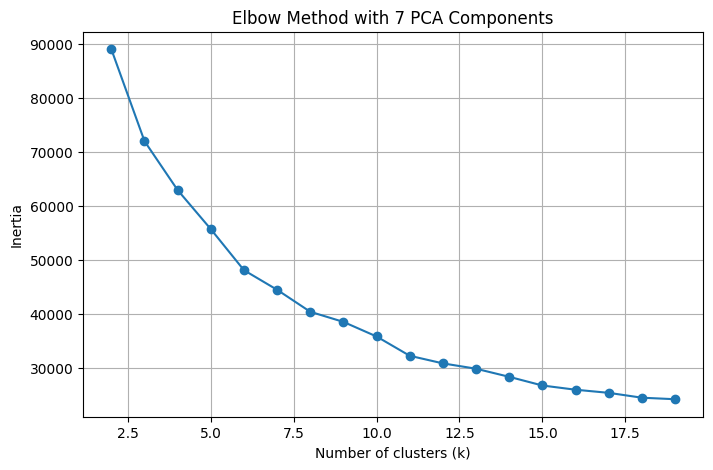

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

n_components_to_use = 7

pca = PCA(n_components=n_components_to_use)
pca_selected_components = pca.fit_transform(scaled_features)

inertia = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_selected_components)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title(f'Elbow Method with {n_components_to_use} PCA Components')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


K-Means

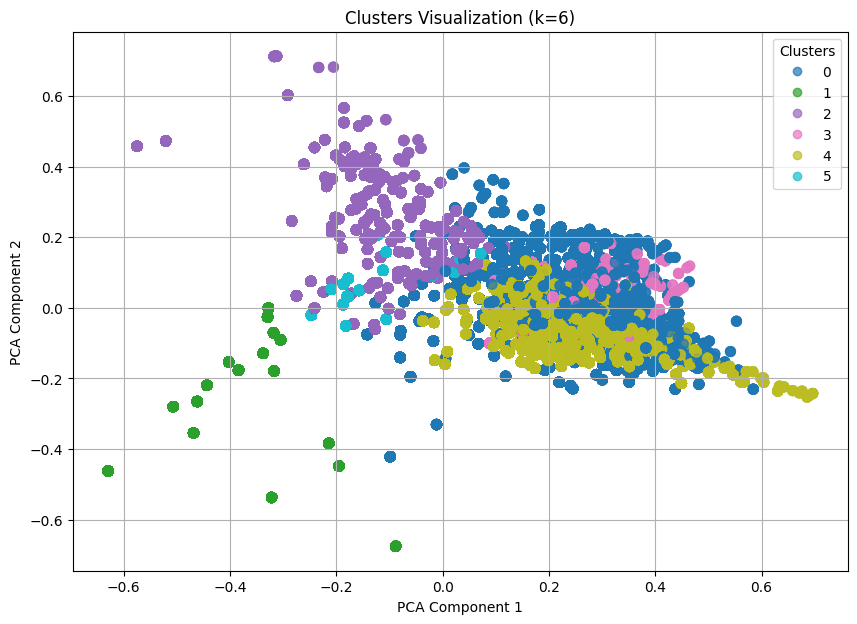

In [38]:
k_chosen = 6

kmeans = KMeans(n_clusters=k_chosen, random_state=42)
cluster_labels = kmeans.fit_predict(pca_selected_components)

pca_2d = PCA(n_components=2)
pca_2d_components = pca_2d.fit_transform(scaled_features)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_2d_components[:, 0], pca_2d_components[:, 1], 
                      c=cluster_labels, cmap='tab10', s=50, alpha=0.7)

plt.title(f'Clusters Visualization (k={k_chosen})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()



3D 

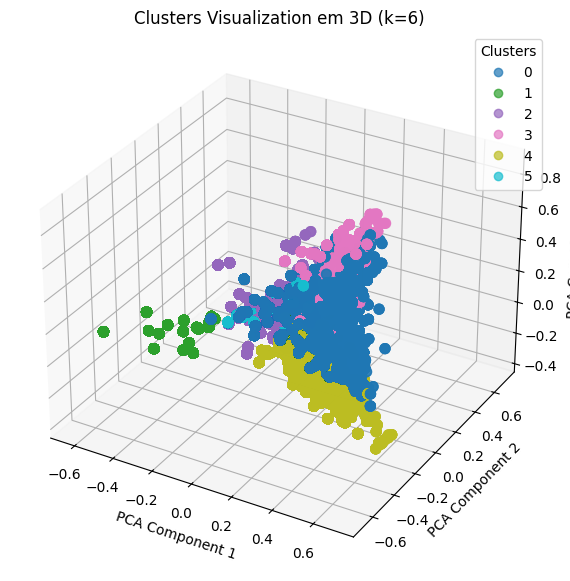

In [39]:
k_chosen = 6

kmeans = KMeans(n_clusters=k_chosen, random_state=42)
cluster_labels = kmeans.fit_predict(pca_selected_components)

pca_3d = PCA(n_components=3)
pca_3d_components = pca_3d.fit_transform(scaled_features)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_3d_components[:, 0],
    pca_3d_components[:, 1],
    pca_3d_components[:, 2],
    c=cluster_labels,
    cmap='tab10',
    s=50,
    alpha=0.7
)

ax.set_title(f'Clusters Visualization em 3D (k={k_chosen})')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

ax.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

UMAP

c:\Users\jgven\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\jgven\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


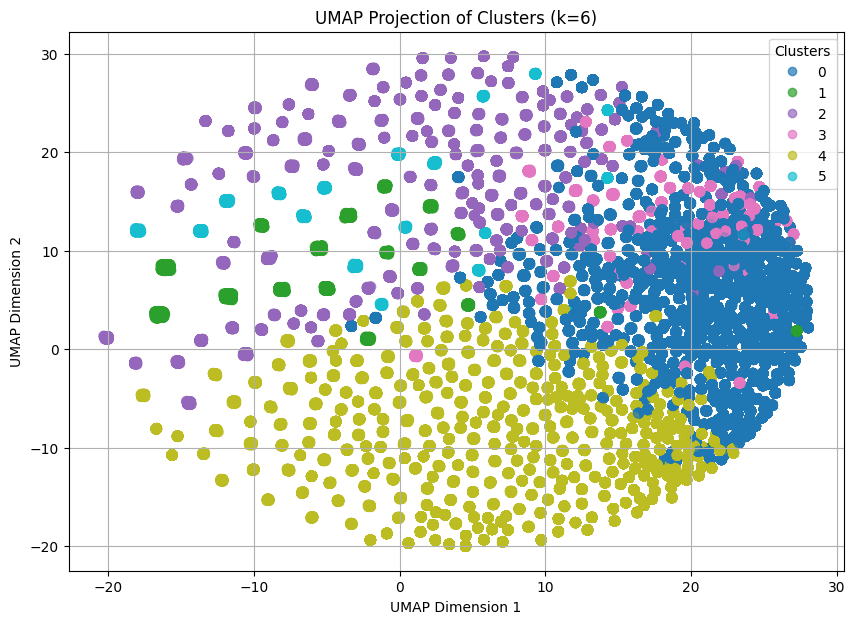

In [40]:
import umap
import matplotlib.pyplot as plt

umap_reducer = umap.UMAP(n_components=2, random_state=42)

umap_embedding = umap_reducer.fit_transform(pca_selected_components) 

plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                      c=cluster_labels, cmap='tab10', s=50, alpha=0.7)

plt.title(f'UMAP Projection of Clusters (k={k_chosen})')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


Cluster Summary

In [44]:
scaled_df['Cluster'] = cluster_labels

cluster_summary = scaled_df.drop(columns=['Client ID']).groupby('Cluster').mean()

cluster_counts = scaled_df['Cluster'].value_counts().sort_index()
cluster_summary['Client Count'] = cluster_counts

pd.set_option('display.max_columns', None)
print(cluster_summary)

         Log_Frequency  Avg_Products_Per_Purchase  Bebidas Alcoólicas  \
Cluster                                                                 
0             0.546792                   0.130721            0.041171   
1             0.784625                   0.650072            0.016565   
2             0.761397                   0.200469            0.027247   
3             0.680866                   0.141137            0.489163   
4             0.741868                   0.137581            0.053799   
5             0.872158                   0.229051            0.005062   

         Bebidas Não-Alcoólicas  Conservas e Enlatados  Doces e Snacks  \
Cluster                                                                  
0                      0.104237               0.069099        0.084809   
1                      0.006628               0.080251        0.086337   
2                      0.043944               0.058962        0.045916   
3                      0.276997              

## Cluster Descriptions – Client Type Segmentation

Based on purchasing behavior across product categories and frequency metrics, we identified six distinct clusters. Each cluster likely corresponds to a specific type of business customer. Below is a formal interpretation of each cluster’s profile:

### Cluster 0 – Frequent Small-Scale Essentials Buyers
- **Behavior:** Moderate frequency of purchases with small average basket sizes. Product consumption is relatively balanced but modest across categories.
- **Likely Business Type:** Small convenience stores that restock frequently in low volumes.

### Cluster 1 – High-Frequency, Broad-Range Buyers
- **Behavior:** Very high frequency of purchases and high product diversity per transaction. High spending across bakery, dairy, vegetables, and meat categories.
- **Likely Business Type:** Hotels, institutional kitchens or large catering services with broad and regular product needs.

### Cluster 2 – Health-Conscious and Fresh-Oriented Buyers
- **Behavior:** High emphasis on fresh categories such as fruits, vegetables, and dairy. Minimal purchase of alcoholic beverages and snacks.
- **Likely Business Type:** Health-focused restaurants, vegetarian cafés, or meal-prep businesses that prioritize fresh and natural ingredients.

### Cluster 3 – Beverage-Centric Buyers
- **Behavior:** Extremely high consumption of alcoholic and non-alcoholic beverages. Minimal to no purchases in other food categories.
- **Likely Business Type:** Liquor stores, bars, clubs, or nightlife establishments whose purchases are concentrated in the beverage category.

### Cluster 4 – Dry Goods and Pantry-Focused Buyers
- **Behavior:** High purchases of non-perishable items such as dry goods, cooking basics, and canned products.
- **Likely Business Type:** Institutional canteens, small wholesalers, or businesses that operate with staple products and long shelf-life inventory.

### Cluster 5 – Bakery and Snack-Oriented Buyers
- **Behavior:** Highest consumption of bakery items and sweet/salty snacks. Also shows above-average interest in dairy and ready-to-consume products.
- **Likely Business Type:** Cafés, snack bars, or pastry shops with a focus on fast-moving and ready-to-eat food categories.



Add ID Client Type into test_data

In [45]:
client_types = data[['Client ID', 'ID Client Type']].drop_duplicates()
test_data = test_data.merge(client_types, on='Client ID', how='left')

test_data.columns

Index(['Client ID', 'Log_Frequency', 'Avg_Products_Per_Purchase',
       'Bebidas Alcoólicas', 'Bebidas Não-Alcoólicas', 'Conservas e Enlatados',
       'Doces e Snacks', 'Laticínios e Ovos', 'Outros', 'Padaria / Pastelaria',
       'Peixaria', 'Produtos Não Alimentares', 'Secos e Básicos de cozinha',
       'Talho', 'Vegetais e Frutas', 'ID Client Type_x', 'ID Client Type_y'],
      dtype='object')

In [51]:
# Filtra apenas colunas numéricas, excluindo 'Client ID'
numeric_columns = test_data.select_dtypes(include='number').columns
columns_to_average = [col for col in numeric_columns if col not in ['Client ID']]

# Faz a média agrupada por tipo de cliente
client_type_summary = test_data.groupby('ID Client Type_x')[columns_to_average].mean()

print(client_type_summary)


                                           Log_Frequency  \
ID Client Type_x                                           
Bar/Discoteca                                   3.813211   
Café/Pastelaria                                 4.233618   
Catering                                        4.266306   
Coletiva/Instituição/Cantina                    4.307067   
Frutaria                                        2.944439   
Garrafeira                                      4.820282   
Hotelaria                                       4.497111   
Mercearia                                       2.397895   
Padaria/Pastelaria                              3.223842   
Restaurante - Brasileiro                        3.433987   
Restaurante - Cervejaria                        4.539975   
Restaurante - Chinês                            3.790603   
Restaurante - Churrasqueira                     3.271477   
Restaurante - Cozinha Portuguesa                4.552486   
Restaurante - Cozinha de Autor          